### ML3 HW3
#### LT5
Borromeo, Chloe<br>
Castanares, Michael Lawrence<br>
Garcia, Fernando Jude<br>
Tan, Allan

Assignment Instructions<br>
Done by LT<br>
Total: 12 points<br>
Submit: Python Notebook (.ipynb)<br>
Task (4pts each method)<br>
Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region<br>

Using the PJM West Region: 2001-2018 (PJMW) estimated hourly energy consumption data from PJM in Megawatts: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data. Forecast the total daily consumption one month in advance. Compare the MAE and MAPE accuracy of the best:<br><br>
ARIMA<br>
LSTM<br>
GRU<br>

### Load the data

In [1]:
import pandas as pd

In [2]:
file = 'data/PJMW_hourly.csv'

In [3]:
df = pd.read_csv(file)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Resample to get daily consumption

In [5]:

df.index = pd.to_datetime(df['Datetime'])
df_daily = df.resample('D').sum('PJMW_MW')


# # # Remove Aug 3 2018 because it does not have a complete day's worth of data

df_daily = df_daily[:-1]

In [6]:
df_daily.describe()

,PJMW_MW
count,5968.000000
mean,134431.675268
std,17722.294237
min,72433.000000
25%,121031.750000
50%,132522.500000
75%,146056.500000
max,211070.000000


### 1. ARIMA

We will normalize the data later on for LSTM, so do the same here so that MAE will be in the same order of magnitude.

In [7]:
cutoff_train = int(len(df_daily) * 0.8)
cutoff_val = int(len(df_daily) * 0.9)

# Normalize data based on the training set
mean = df_daily['PJMW_MW'][:cutoff_train].mean(axis=0)
std = df_daily['PJMW_MW'][:cutoff_train].std(axis=0)
normalized_data = (df_daily['PJMW_MW'] - mean) / std



In [8]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


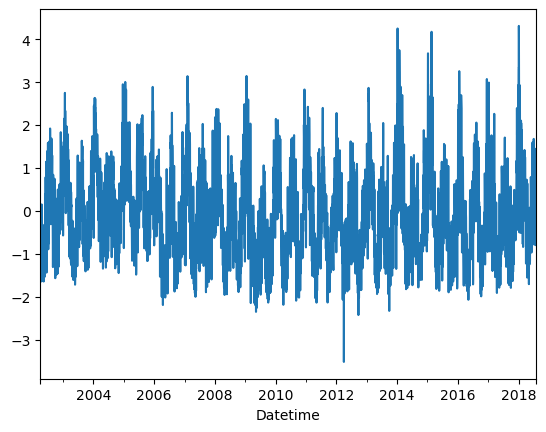

In [9]:
from matplotlib import pyplot
%matplotlib inline
normalized_data.plot()
pyplot.show()

The data needs to be stationary for ARIMA to work. Let's check that.

In [10]:
# ! conda install statsmodels -y

In [14]:
from statsmodels.tsa.stattools import adfuller

series = normalized_data
# Perform the ADF test to check stationarity
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.264578
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The results show that the test statistic value -7.264578 is smaller than the critical value at 1% of -3.431. This suggests the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

In [12]:
# ! conda install scikit-learn -y

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm 
import timeit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    days_in_a_month = 30  # Define the number of days in a month
    train_size = int(len(X) - 2 * days_in_a_month)  # Use 2 month validation
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)


    # Make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        # Difference data
        diff = difference(history, days_in_a_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=30)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, days_in_a_month)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (MAE)
    mae = mean_absolute_error(test, predictions)
    return mae


In [16]:
X = series.values
start = timeit.default_timer()
mar = evaluate_arima_model(X, (0, 0, 1))
exec_time = timeit.default_timer() - start
print(f'MAE={mar} Execution Time: {exec_time}')


100%|██████████| 60/60 [00:26<00:00,  2.25it/s]

MAE=0.5132327516655102 Execution Time: 26.676316168013727


Do GridSearch to find the optimal values of p,d and q

In [17]:
from itertools import product

# Define ranges for p, d, q
p_range = range(0, 6)
d_range = range(0, 1)
q_range = range(0, 6)

# Initialize a dictionary to store the results
results = {}
start = timeit.default_timer()
# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    try:
        mae = evaluate_arima_model(X, order)
        # Store the result in the dictionary
        results[order] = mae
        print(f"Order {order}, MAE: {mae}")
    except:
        print(f"Error trying to converge Order {order}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_mae = results[best_order]
exec_time = timeit.default_timer() - start
# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest MAE: {best_mae}, Execution Time: {exec_time}")

100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


Order (0, 0, 0), MAE: 0.7984603901361985


100%|██████████| 60/60 [00:23<00:00,  2.57it/s]


Order (0, 0, 1), MAE: 0.5132327516655102


100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


Order (0, 0, 2), MAE: 0.4661869897373169


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]


Order (0, 0, 3), MAE: 0.473521439122592


100%|██████████| 60/60 [01:02<00:00,  1.05s/it]


Order (0, 0, 4), MAE: 0.45567791371270217


100%|██████████| 60/60 [01:14<00:00,  1.25s/it]


Order (0, 0, 5), MAE: 0.45702266823148224


100%|██████████| 60/60 [00:11<00:00,  5.05it/s]


Order (1, 0, 0), MAE: 0.5175340537418239


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


Order (1, 0, 1), MAE: 0.47109508350343465


100%|██████████| 60/60 [00:50<00:00,  1.18it/s]


Order (1, 0, 2), MAE: 0.4693130986317886


100%|██████████| 60/60 [01:20<00:00,  1.35s/it]


Order (1, 0, 3), MAE: 0.4611257981931513


100%|██████████| 60/60 [01:47<00:00,  1.79s/it]


Order (1, 0, 4), MAE: 0.45619041830038853


100%|██████████| 60/60 [02:23<00:00,  2.39s/it]


Order (1, 0, 5), MAE: 0.4662123813379424


100%|██████████| 60/60 [00:17<00:00,  3.41it/s]


Order (2, 0, 0), MAE: 0.5172267459933624


 97%|█████████▋| 58/60 [00:46<00:01,  1.05it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 60/60 [00:49<00:00,  1.21it/s]


Order (2, 0, 1), MAE: 0.4714429309000264


100%|██████████| 60/60 [01:13<00:00,  1.22s/it]


Order (2, 0, 2), MAE: 0.467561393622089


100%|██████████| 60/60 [01:48<00:00,  1.80s/it]


Order (2, 0, 3), MAE: 0.456996695358167


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:04<04:18,  4.39s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:08<04:06,  4.25s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:12<03:55,  4.13s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (2, 0, 4), MAE: 0.4550454078806768


100%|██████████| 60/60 [03:16<00:00,  3.28s/it]


Order (2, 0, 5), MAE: 0.463583207854368


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


Order (3, 0, 0), MAE: 0.4746807655594523


100%|██████████| 60/60 [00:39<00:00,  1.54it/s]


Order (3, 0, 1), MAE: 0.45222857926593935


100%|██████████| 60/60 [01:44<00:00,  1.74s/it]


Order (3, 0, 2), MAE: 0.47397908254559395


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:04<04:22,  4.45s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:09<04:38,  4.80s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:14<04:29,  4.73s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (3, 0, 3), MAE: 0.4543864534158191


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:05<05:07,  5.21s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:10<05:14,  5.42s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:15<04:57,  5.22s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (3, 0, 4), MAE: 0.4485794585390645


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:06<06:27,  6.56s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:20<06:30,  6.86s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 4/60 [00:26<06:08,  6.58s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (3, 0, 5), MAE: 0.44644247408454113


100%|██████████| 60/60 [00:28<00:00,  2.12it/s]


Order (4, 0, 0), MAE: 0.45036711892974274


100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


Order (4, 0, 1), MAE: 0.44537518214068333


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:04<04:11,  4.27s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:08<04:03,  4.21s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:12<03:51,  4.07s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 2), MAE: 0.4710865836042963


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:04<04:22,  4.45s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:08<04:18,  4.46s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:13<04:13,  4.45s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 3), MAE: 0.4563090686671471


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:05<05:03,  5.14s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:10<04:53,  5.06s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:15<04:44,  5.00s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 4), MAE: 0.4369408072263576


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:06<05:59,  6.09s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:11<05:45,  5.95s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:17<05:40,  5.98s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (4, 0, 5), MAE: 0.4452203688297639


100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Order (5, 0, 0), MAE: 0.448620478398446


100%|██████████| 60/60 [03:23<00:00,  3.39s/it]


Order (5, 0, 1), MAE: 0.45127299068246624


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:05<05:47,  5.89s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:11<05:46,  5.97s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:18<05:44,  6.04s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 2), MAE: 0.44190340809403367


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:05<05:38,  5.73s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:11<05:36,  5.80s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:17<05:24,  5.69s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 3), MAE: 0.43361885901202857


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:05<05:53,  5.99s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:11<05:34,  5.77s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:17<05:35,  5.88s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 4), MAE: 0.4615794914126569


  0%|          | 0/60 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/60 [00:07<07:48,  7.94s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 2/60 [00:15<07:16,  7.53s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 3/60 [00:22<07:10,  7.55s/it]/home/andy/miniconda3/envs/gpu2/lib/python3.12/site-packages/statsmodels/base/model.py:607: Con

Order (5, 0, 5), MAE: 0.4579281872281735

Best Order: (5, 0, 3), Lowest MAE: 0.43361885901202857, Execution Time: 5570.222763484024


### 2. LSTM

In [16]:
import torch
import torch.nn as nn
pytorch_gpu_available = torch.cuda.is_available()
print(f"GPU (CUDA) is available: {pytorch_gpu_available}")
if pytorch_gpu_available:
    print(f"Number of available GPUs: {torch.cuda.device_count()}")


GPU (CUDA) is available: True
Number of available GPUs: 1


In [17]:
from torch.utils.data import Dataset, DataLoader

In [73]:
# convert dates into epoch seconds
df_daily['Time'] = (df_daily.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
ts_data = df_daily[['Time', 'PJMW_MW']]
ts_data.reset_index(inplace=True, drop=True)
ts_data.head()

,Time,PJMW_MW
0,1017619200,121237.0
1,1017705600,127450.0
2,1017792000,127822.0
3,1017878400,136099.0
4,1017964800,136467.0


Normalize the data<br>
Training data is 0-80%<br>
Validation Data is 80-90%<br>
Test Data is last 10%

In [74]:
cutoff_train = int(len(df_daily) * 0.8)
cutoff_val = int(len(df_daily) * 0.9)
float_data = ts_data.to_numpy()
# Normalize data based on the training set
mean = float_data[:cutoff_train].mean(axis=0)
std = float_data[:cutoff_train].std(axis=0)
normalized_data = (float_data - mean) / std



In [75]:
from torch.utils.data import Dataset

class PJMWBDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = max_index if max_index is not None else len(data) - delay - 1
        self.step = step

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        i = self.min_index + index + self.lookback
        indices = range(i - self.lookback, i, self.step)
        samples = self.data[indices]
        target = self.data[i + self.delay][-1]  # last column column (index -1) is the target variable
        # print(samples.shape)
        return torch.tensor(samples, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)




In [76]:
print(normalized_data.shape)

(5968, 2)


Look back 120 days, 1 data point per day, predict the next 30th day

In [77]:
NUM_WORKERS = 1

lookback = 120 # 120 days
step = 1
delay = 30 * 2 # predict next 30 days
batch_size = 120

train_dataset = PJMWBDataset(normalized_data, lookback, delay, 0, cutoff_train, step)
val_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_train + 1, cutoff_val, step)
test_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_val + 1, None, step)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)



Baseline - Naive Model

In [78]:
def evaluate_naive_method(loader):
    pred_history = []
    target_history = []
    maes = []
    for samples, targets in loader:
        print(samples.shape)
        preds = samples[:, -1 , 1]  # last time step's temperature as prediction
        print(preds.shape)
        # print(f'SAMPLES {samples.shape} PREDS {preds.shape} TARGETS {targets.shape}')
        mae = torch.mean(torch.abs(preds - targets))
        maes.append(mae.item())
        pred_history += (preds)
        target_history += (targets)
    return (np.mean(maes), pred_history, target_history)

# Evaluate
naive_mae, pred_history, target_history = evaluate_naive_method(val_loader)
print(f"Naive method MAE on validation set: {naive_mae}")

torch.Size([120, 120, 2])
torch.Size([120])
torch.Size([120, 120, 2])
torch.Size([120])
torch.Size([120, 120, 2])
torch.Size([120])
torch.Size([117, 120, 2])
torch.Size([117])
Naive method MAE on validation set: 1.358948528766632


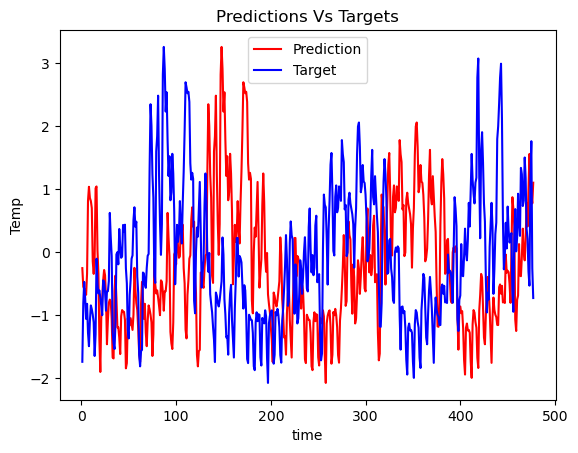

In [79]:
import matplotlib.pyplot as plt


x_axis = range(1, len(pred_history) + 1)

plt.figure()

plt.plot(x_axis, pred_history, 'r', label='Prediction')
plt.plot(x_axis, target_history, 'b', label='Target')
plt.title('Predictions Vs Targets')
plt.xlabel('time')
plt.ylabel('Temp')
plt.legend()

plt.show()

Feed Forward Neural Net

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Determine input shape based on your data structure
input_shape = (lookback // step, normalized_data.shape[-1])
print(input_shape)
model = Net(input_shape)

# Print model architecture
print(model)

(120, 2)
Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [98]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(1, input_shape[0], input_shape[1]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Flatten: 1-1                           [1, 240]                  --
├─Linear: 1-2                            [1, 32]                   7,712
├─ReLU: 1-3                              [1, 32]                   --
├─Linear: 1-4                            [1, 1]                    33
Total params: 7,745
Trainable params: 7,745
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [99]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []


# Training loop
def train_model(model, train_loader, val_loader, epochs):
    pred_history = []
    target_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()
                train_loss += loss.item()
                output_shape = outputs.cpu().detach().numpy()[:,0].shape[0]
                preds_array = outputs.cpu().detach().numpy()[:,0].reshape(output_shape).tolist()
                target_array = targets.cpu().detach().numpy().reshape(output_shape).tolist()
                # print(preds_array)
                pred_history += preds_array
                target_history += target_array


        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return (pred_history, target_history)
# Train the model
pred_history, target_history = train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 3.5130, Val Loss: 0.8783
Epoch 2/20, Train Loss: 3.6590, Val Loss: 0.9147
Epoch 3/20, Train Loss: 3.4151, Val Loss: 0.8538
Epoch 4/20, Train Loss: 3.4510, Val Loss: 0.8627
Epoch 5/20, Train Loss: 3.4041, Val Loss: 0.8510
Epoch 6/20, Train Loss: 3.4360, Val Loss: 0.8590
Epoch 7/20, Train Loss: 3.3928, Val Loss: 0.8482
Epoch 8/20, Train Loss: 3.3929, Val Loss: 0.8482
Epoch 9/20, Train Loss: 3.4051, Val Loss: 0.8513
Epoch 10/20, Train Loss: 3.4203, Val Loss: 0.8551
Epoch 11/20, Train Loss: 3.4016, Val Loss: 0.8504
Epoch 12/20, Train Loss: 3.3988, Val Loss: 0.8497
Epoch 13/20, Train Loss: 3.3981, Val Loss: 0.8495
Epoch 14/20, Train Loss: 3.3997, Val Loss: 0.8499
Epoch 15/20, Train Loss: 3.5261, Val Loss: 0.8815
Epoch 16/20, Train Loss: 3.4025, Val Loss: 0.8506
Epoch 17/20, Train Loss: 3.4013, Val Loss: 0.8503
Epoch 18/20, Train Loss: 3.4178, Val Loss: 0.8545
Epoch 19/20, Train Loss: 3.4001, Val Loss: 0.8500
Epoch 20/20, Train Loss: 3.4026, Val Loss: 0.8506


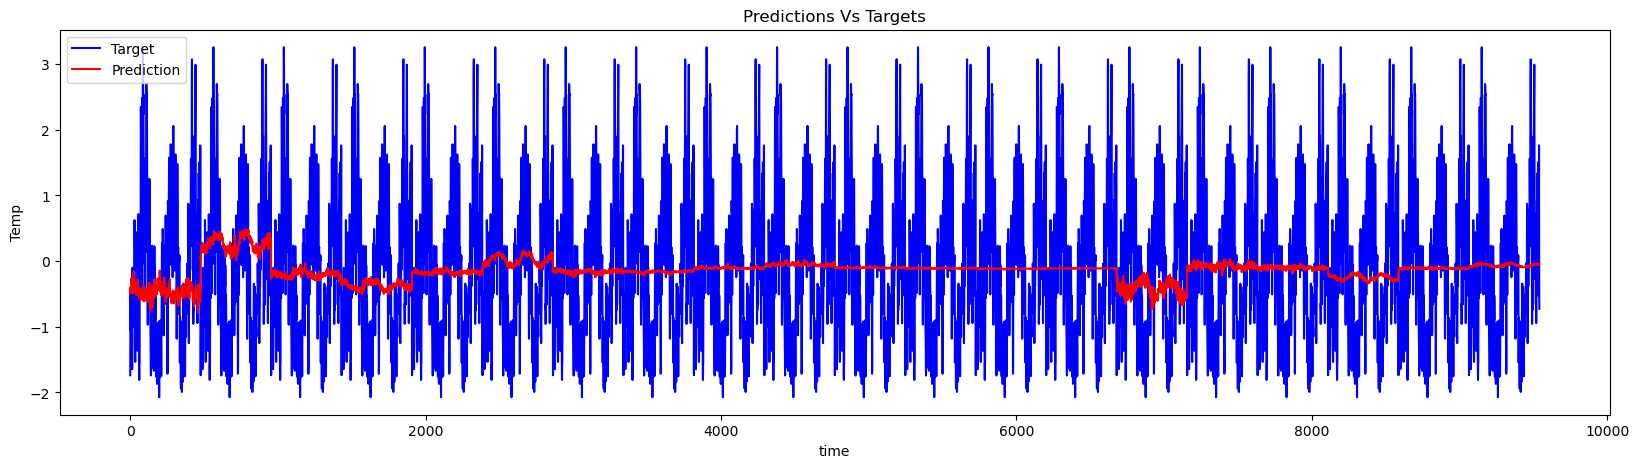

In [100]:
# print(pred_history)
x_axis = range(1, len(pred_history) + 1)

plt.figure(figsize=(20,5))
plt.plot(x_axis, target_history, 'b', label='Target')
plt.plot(x_axis, pred_history, 'r', label='Prediction')
plt.title('Predictions Vs Targets')
plt.xlabel('time')
plt.ylabel('Temp')
plt.legend()

plt.show()

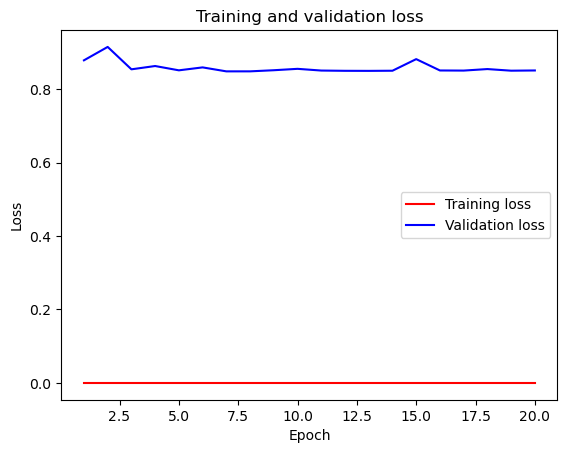

In [101]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

LSTM

In [120]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # LSTM Layer:
        # - 32 units, as in the Keras model
        # - input_size is the number of features
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        # Dense Layer:
        # - 32 (from LSTM) to 1 output (since we're predicting one value)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        # We only care about the last output of LSTM for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            lstm_out = lstm_out[:, -1, :]  # Take last time step
        else:  # If not batched
            lstm_out = lstm_out[-1, :]  # Take last time step

        # Pass through dense layer
        output = self.dense(lstm_out)
        return output

# Define the model with the right input size
input_size = 2  # Number of features in your data
model = LSTMModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

LSTMModel(
  (lstm): LSTM(2, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 4641


In [121]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):
    pred_history = []
    target_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()
                train_loss += loss.item()
                output_shape = outputs.cpu().detach().numpy()[:,0].shape[0]
                preds_array = outputs.cpu().detach().numpy()[:,0].reshape(output_shape).tolist()
                target_array = targets.cpu().detach().numpy().reshape(output_shape).tolist()
                # print(preds_array)
                pred_history += preds_array
                target_history += target_array

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return (pred_history, target_history)
# Train the model
pred_history, target_history = train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 4.1788, Val Loss: 0.8431
Epoch 2/20, Train Loss: 3.9982, Val Loss: 0.8053
Epoch 3/20, Train Loss: 3.3988, Val Loss: 0.6686
Epoch 4/20, Train Loss: 3.6537, Val Loss: 0.7390
Epoch 5/20, Train Loss: 3.7727, Val Loss: 0.7765
Epoch 6/20, Train Loss: 3.8423, Val Loss: 0.7980
Epoch 7/20, Train Loss: 4.2319, Val Loss: 0.8983
Epoch 8/20, Train Loss: 3.9866, Val Loss: 0.8392
Epoch 9/20, Train Loss: 4.3438, Val Loss: 0.9336
Epoch 10/20, Train Loss: 4.3485, Val Loss: 0.9422
Epoch 11/20, Train Loss: 3.1840, Val Loss: 0.6504
Epoch 12/20, Train Loss: 3.4968, Val Loss: 0.7298
Epoch 13/20, Train Loss: 4.2322, Val Loss: 0.9189
Epoch 14/20, Train Loss: 4.1094, Val Loss: 0.8909
Epoch 15/20, Train Loss: 3.7268, Val Loss: 0.7960
Epoch 16/20, Train Loss: 3.8524, Val Loss: 0.8314
Epoch 17/20, Train Loss: 3.8988, Val Loss: 0.8478
Epoch 18/20, Train Loss: 3.5515, Val Loss: 0.7565
Epoch 19/20, Train Loss: 3.8054, Val Loss: 0.8226
Epoch 20/20, Train Loss: 4.2030, Val Loss: 0.9243


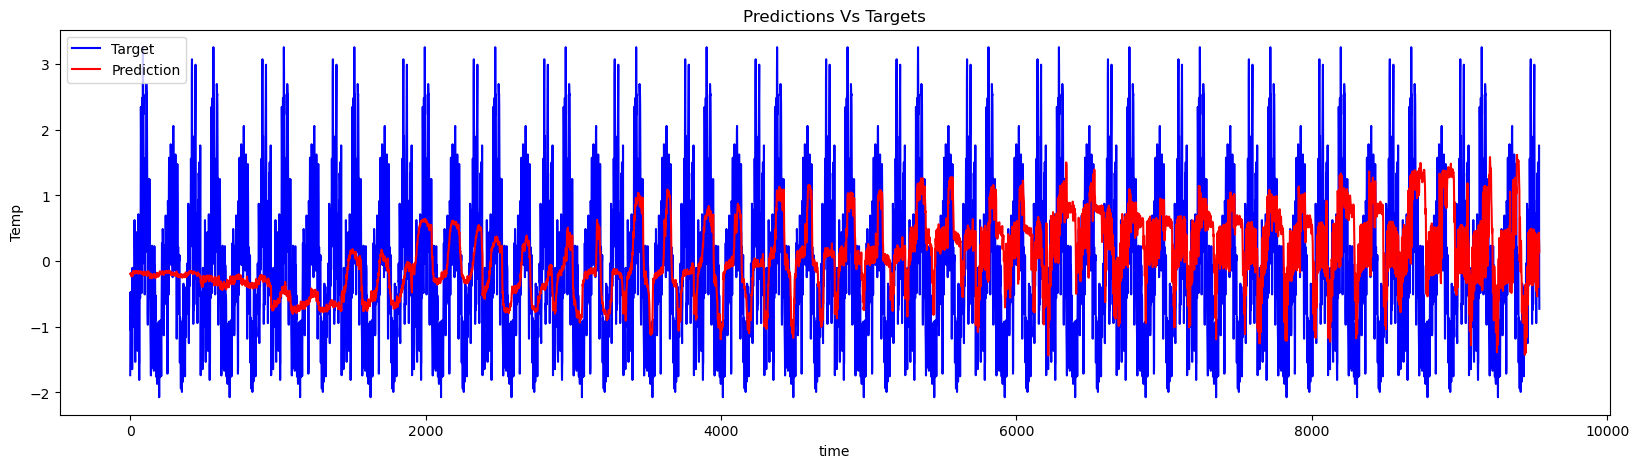

In [104]:
# print(pred_history)
x_axis = range(1, len(pred_history) + 1)

plt.figure(figsize=(20,5))
plt.plot(x_axis, target_history, 'b', label='Target')
plt.plot(x_axis, pred_history, 'r', label='Prediction')
plt.title('Predictions Vs Targets')
plt.xlabel('time')
plt.ylabel('Temp')
plt.legend()

plt.show()

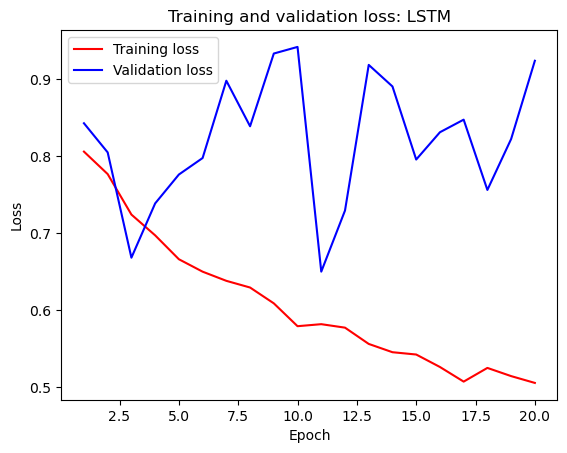

In [122]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss: LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 3. GRU

In [115]:

class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # GRU expects input of shape (batch_size, sequence_length, features)
        gru_out, _ = self.gru(x)
        # We only care about the last output of GRU for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            gru_out = gru_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru_out = gru_out[-1, :]  # Take last time step

        output = self.dense(gru_out)
        return output

# Define the model with the right input size
input_size = 2
model = GRUModel(input_size)

# Print model summary
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru): GRU(2, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 3489


In [116]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):
    pred_history = []
    target_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()
                output_shape = outputs.cpu().detach().numpy()[:,0].shape[0]
                preds_array = outputs.cpu().detach().numpy()[:,0].reshape(output_shape).tolist()
                target_array = targets.cpu().detach().numpy().reshape(output_shape).tolist()
                # print(preds_array)
                pred_history += preds_array
                target_history += target_array

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return (pred_history, target_history)
# Train the model
pred_history, target_history = train_model(model, train_loader, val_loader, epochs=20)

cuda
Epoch 1/20, Train Loss: 0.8242, Val Loss: 0.7317
Epoch 2/20, Train Loss: 0.7281, Val Loss: 0.6312
Epoch 3/20, Train Loss: 0.6988, Val Loss: 0.7090
Epoch 4/20, Train Loss: 0.6840, Val Loss: 0.6794
Epoch 5/20, Train Loss: 0.6716, Val Loss: 0.7848
Epoch 6/20, Train Loss: 0.6568, Val Loss: 0.7870
Epoch 7/20, Train Loss: 0.6432, Val Loss: 0.6905
Epoch 8/20, Train Loss: 0.6285, Val Loss: 0.9212
Epoch 9/20, Train Loss: 0.6151, Val Loss: 0.7400
Epoch 10/20, Train Loss: 0.6096, Val Loss: 0.8778
Epoch 11/20, Train Loss: 0.5918, Val Loss: 0.7441
Epoch 12/20, Train Loss: 0.5791, Val Loss: 0.9649
Epoch 13/20, Train Loss: 0.5697, Val Loss: 0.9907
Epoch 14/20, Train Loss: 0.5631, Val Loss: 0.9819
Epoch 15/20, Train Loss: 0.5545, Val Loss: 0.9021
Epoch 16/20, Train Loss: 0.5431, Val Loss: 0.8598
Epoch 17/20, Train Loss: 0.5471, Val Loss: 0.9622
Epoch 18/20, Train Loss: 0.5367, Val Loss: 0.9227
Epoch 19/20, Train Loss: 0.5325, Val Loss: 0.7457
Epoch 20/20, Train Loss: 0.5212, Val Loss: 0.9583


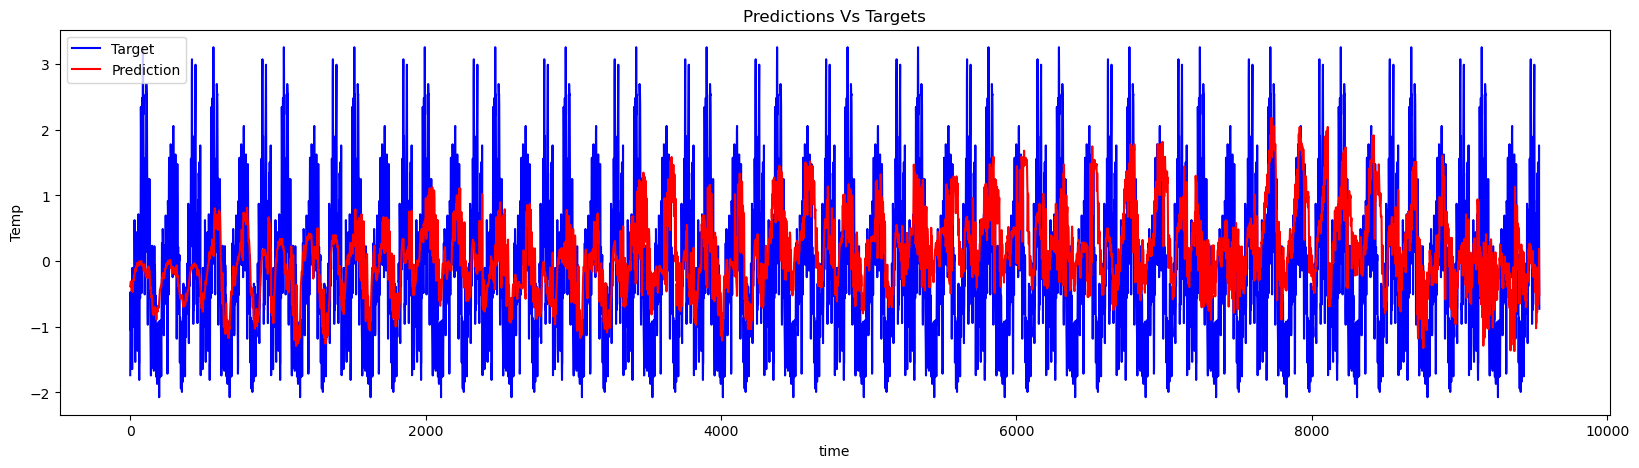

In [119]:
# print(pred_history)
x_axis = range(1, len(pred_history) + 1)

plt.figure(figsize=(20,5))
plt.plot(x_axis, target_history, 'b', label='Target')
plt.plot(x_axis, pred_history, 'r', label='Prediction')
plt.title('Predictions Vs Targets')
plt.xlabel('time')
plt.ylabel('Temp')
plt.legend()

plt.show()

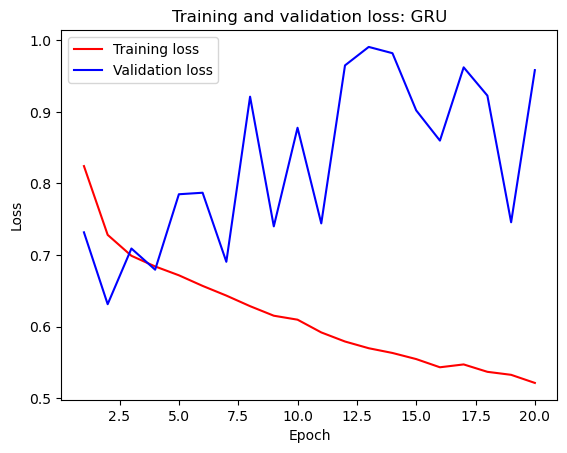

In [118]:
import matplotlib.pyplot as plt

max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss: GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Stack Recurrent Layers

In [123]:
class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        # First GRU Layer:
        self.gru1 = nn.GRU(input_size, 16, dropout=0.1, bidirectional=False, batch_first=True)
        # Here, we manually set recurrent_dropout using a custom wrapper
        self.gru1_dropout = nn.Dropout(0.2)

        # Second GRU Layer:
        self.gru2 = nn.GRU(16, 32, dropout=0.1, bidirectional=False, batch_first=True)
        self.gru2_dropout = nn.Dropout(0.2)

        # Dense Layer:
        self.dense = nn.Linear(32, 1)

        # Activation for the second GRU layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # First GRU layer with recurrent dropout
        gru1_out, _ = self.gru1(x)
        gru1_out = self.gru1_dropout(gru1_out)

        # Second GRU layer
        gru2_out, _ = self.gru2(gru1_out)
        gru2_out = self.gru2_dropout(gru2_out)
        gru2_out = self.relu(gru2_out)

        # We take the last output of the sequence for prediction
        if x.dim() == 3:  # (batch, seq, feature)
            gru2_out = gru2_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru2_out = gru2_out[-1, :]  # Take last time step

        # Dense layer
        output = self.dense(gru2_out)
        return output

# Define the model with the right input size
input_size = 2  # Number of features in your data
model = GRUModel(input_size)

# Print model summary
print(model)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru1): GRU(2, 16, batch_first=True, dropout=0.1)
  (gru1_dropout): Dropout(p=0.2, inplace=False)
  (gru2): GRU(16, 32, batch_first=True, dropout=0.1)
  (gru2_dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
Total parameters: 5793


In [124]:
# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss and optimizer
criterion = nn.L1Loss()  # MAE in PyTorch
optimizer = optim.RMSprop(model.parameters())

# We'll use these lists to store loss history
train_losses = []
val_losses = []

# Training loop
def train_model(model, train_loader, val_loader, epochs):

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Store the average loss for plotting

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))
                val_loss += loss.item()

        # Average validation loss for this epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Store the average validation loss for plotting

        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

cuda


Epoch 1/20, Train Loss: 0.7848, Val Loss: 0.7907
Epoch 2/20, Train Loss: 0.6954, Val Loss: 0.6722
Epoch 3/20, Train Loss: 0.6542, Val Loss: 0.6605
Epoch 4/20, Train Loss: 0.6110, Val Loss: 1.0661
Epoch 5/20, Train Loss: 0.5983, Val Loss: 0.6156
Epoch 6/20, Train Loss: 0.5710, Val Loss: 0.7450
Epoch 7/20, Train Loss: 0.5580, Val Loss: 0.6643
Epoch 8/20, Train Loss: 0.5512, Val Loss: 0.6724
Epoch 9/20, Train Loss: 0.5393, Val Loss: 0.6605
Epoch 10/20, Train Loss: 0.5337, Val Loss: 0.6525
Epoch 11/20, Train Loss: 0.5281, Val Loss: 0.6861
Epoch 12/20, Train Loss: 0.5233, Val Loss: 0.7274
Epoch 13/20, Train Loss: 0.5254, Val Loss: 0.6746
Epoch 14/20, Train Loss: 0.5150, Val Loss: 0.6722
Epoch 15/20, Train Loss: 0.4971, Val Loss: 0.6486
Epoch 16/20, Train Loss: 0.4991, Val Loss: 0.6980
Epoch 17/20, Train Loss: 0.4975, Val Loss: 0.6598
Epoch 18/20, Train Loss: 0.4891, Val Loss: 0.6974
Epoch 19/20, Train Loss: 0.4934, Val Loss: 0.6284
Epoch 20/20, Train Loss: 0.4826, Val Loss: 0.7836


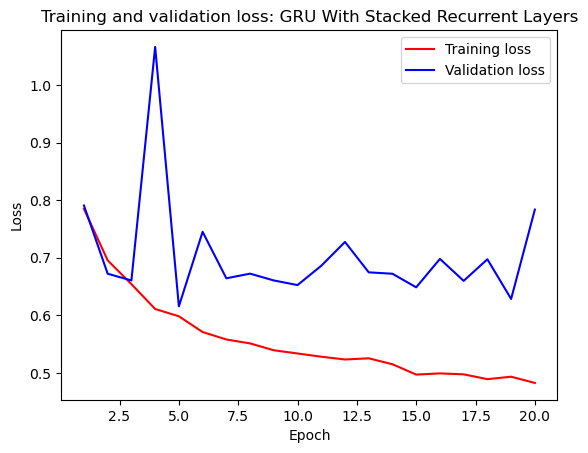

In [125]:
max_loss_threshold = 2

# Clip the losses to this threshold
clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

# Plotting the loss curves
epochs = range(1, len(train_losses) + 1)

plt.figure()

plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
plt.plot(epochs, clipped_val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss: GRU With Stacked Recurrent Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()